In [1]:
from easyclean import datasets
import pandas as pd
from utils import sequence_utils

In [2]:
originalDataset = "datasets/IMDBDatasetSPANISH.csv"
pandasDF = pd.read_csv(originalDataset)
filas = ['review_es', 'sentiment'] #columnas por mantener
DF = datasets.delete(pandasDF, filas)
print(DF)

                                               review_es sentiment
0      Uno de los otros críticos ha mencionado que de...  positive
1      Una pequeña pequeña producción.La técnica de f...  positive
2      Pensé que esta era una manera maravillosa de p...  positive
3      Básicamente, hay una familia donde un niño peq...  negative
4      El "amor en el tiempo" de Petter Mattei es una...  positive
...                                                  ...       ...
49995  Pensé que esta película hizo un buen trabajo a...  positive
49996  Mala parcela, mal diálogo, mala actuación, dir...  negative
49997  Soy católica enseñada en escuelas primarias pa...  negative
49998  Voy a tener que estar en desacuerdo con el com...  negative
49999  Nadie espera que las películas de Star Trek se...  negative

[50000 rows x 2 columns]


In [3]:
DF = sequence_utils.filter_string(DF, 'review_es',160)
print(DF)

                                               review_es sentiment
3      Básicamente, hay una familia donde un niño peq...  negative
5      Probablemente mi película favorita de todos lo...  positive
6      Seguro que me gustaría ver una resurrección de...  positive
8      Alentados por los comentarios positivos sobre ...  negative
9      Si te gusta la risa original desgarradora, te ...  positive
...                                                  ...       ...
49987  Una nueva versión de Alejandro Amenabar's Abre...  negative
49990  Cojo, cojo, cojo !!!Un festival de 90 minutos ...  negative
49994  Esta es tu comedia de chatarra típica. Casi no...  negative
49996  Mala parcela, mal diálogo, mala actuación, dir...  negative
49999  Nadie espera que las películas de Star Trek se...  negative

[22692 rows x 2 columns]


In [4]:
DF

,review_es,sentiment
3,"Básicamente, hay una familia donde un niño peq...",negative
5,Probablemente mi película favorita de todos lo...,positive
6,Seguro que me gustaría ver una resurrección de...,positive
8,Alentados por los comentarios positivos sobre ...,negative
9,"Si te gusta la risa original desgarradora, te ...",positive
...,...,...
49987,Una nueva versión de Alejandro Amenabar's Abre...,negative
49990,"Cojo, cojo, cojo !!!Un festival de 90 minutos ...",negative
49994,Esta es tu comedia de chatarra típica. Casi no...,negative
49996,"Mala parcela, mal diálogo, mala actuación, dir...",negative


In [5]:
listDatasets = [DF, "datasets/filmaffinity", "datasets/muchocine", 2]
headers = ['text', 'sentiment']
newDatasets = datasets.join(listDatasets, headers)
print(newDatasets)
print(newDatasets.shape)

undetected element with index: 3
                                                    text sentiment
0      Básicamente, hay una familia donde un niño peq...  negative
1      Probablemente mi película favorita de todos lo...  positive
2      Seguro que me gustaría ver una resurrección de...  positive
3      Alentados por los comentarios positivos sobre ...  negative
4      Si te gusta la risa original desgarradora, te ...  positive
...                                                  ...       ...
35162  Película dirigida a un público adolescente, co...         0
35163  Bergman en estado puro. Duro a la par que sens...         0
35164  Por fin vemos un Almodóvar que retrata escenas...         0
35165  Dos horas entretenidillas de thriller con cier...         0
35166  La película es entretenida e interesante, sobr...         0

[35167 rows x 2 columns]
(35167, 2)


In [6]:
from transformers import BertTokenizer

In [7]:
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'

In [8]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/jose/Documents/thesis/RecSys/utils/sequence_utils.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


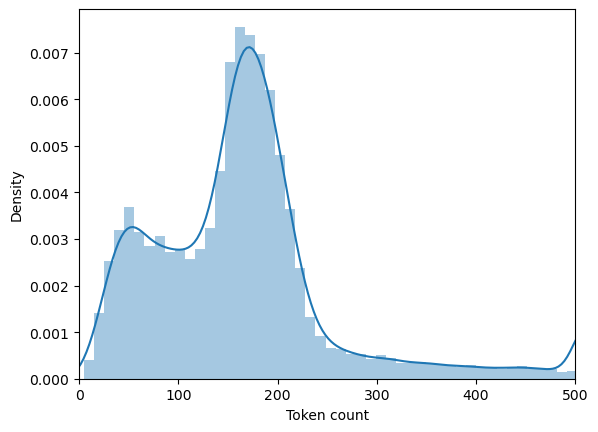

In [9]:
sequence_utils.plot_token_count(newDatasets.text, tokenizer)

Lo anterior sin considerar el selectTexts (160) de beto_colab.ipynb